# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear model, partake in additional exploratory analysis in order to engineer explanatory features and run linear regressions that attempt to answer a question that Kiva borrowers may have: 

*What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. 

Here's a look ahead at what we'll be doing in this notebook: 

1. Load data and packages 

2. Feature engineering and selection

3. Check our assumptions 

4. Linear Regression

5. Model Validation


## **If you haven't already, please run through Notebook 1!**  You need the final ouput df_module_1.csv.

As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1 module_1_exploratory_analysis_with_solutions, we merged these data files and created new variables to form the data frame "df_module_1", we exported it as df_module_1.csv. We will use this dataframe now. 

First, we will load the packages we need for this section, and our data. 

In [219]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
from bs4 import BeautifulSoup
import re as re
import types
import seaborn as sns
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

# packages for linear regression and validation 
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

#package for location features, if you do not already have this and it throw an error run pip install geopy from your
#terminal
from geopy.geocoders import Nominatim

In [10]:
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [223]:
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [12]:
# Read in data
data_path = '~/intro_course_data_science_for_good/data/'
df = pd.read_csv(data_path+'df_module_1.csv', low_memory=False)

## Remove Loan Amount Outliers

In the exploratory module we introduced the concept of outliers and showed why it might be important to remove outlier loan amounts. Outliers are not strictly defined, but here, we suggest that a reasonable definition of an outlier is an observation that falls outside 3 standard deviations from the mean. In laymans terms, this means that an outlier is on the very tail end of a distribution. For a more rigorous definition of a standard deviation, read [here](http://mathworld.wolfram.com/Outlier.html).

Our data is very skewed by several extreme loan amount outliers. Now that we are considering a linear regression model, we should revisit removing our loan_amount outliers completely since they will cause bias in our results.

First, we look at the distribution of loans with outliers included.

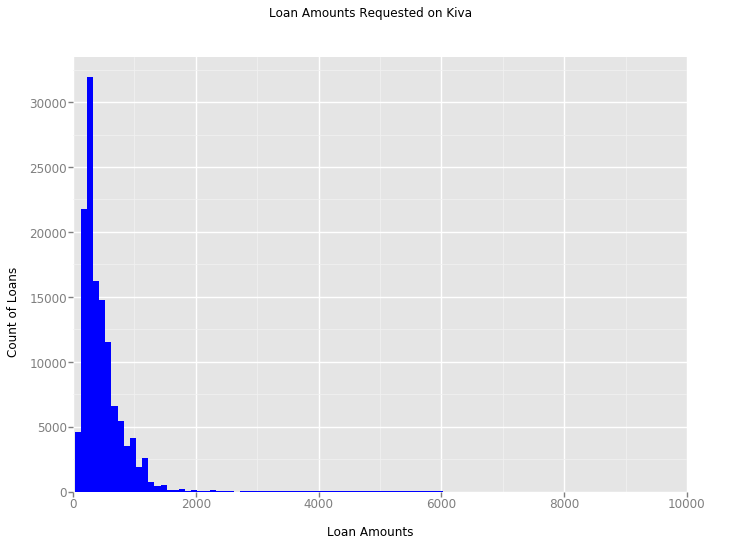

<ggplot: (348793436)>

In [19]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We first analyze the implications of removing outliers by creating a new dataframe without outliers. We call this df_removed_outliers. We can immediately see that the data is less skewed. This suggests we should remove outliers from our df dataframe permanently.

In [20]:
# Calculate Outliers
df_removed_outliers=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

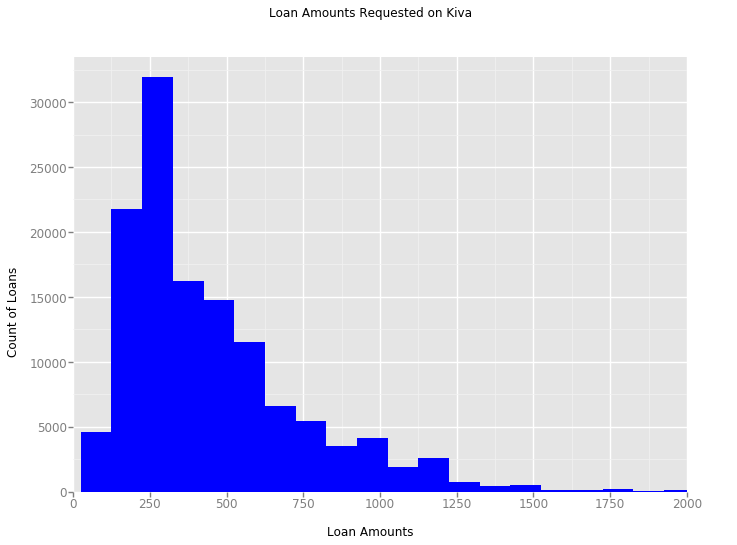

<ggplot: (-9223372036526786153)>

In [21]:
ggplot(df_removed_outliers, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 2000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We should also examine what these outliers are to make sure they make sense excluding. We can see from the sample below that many of the biggest loans are for education grants. However, since so many of our loans are for $250, we conclude that the outliers are not representative of the typical Kiva borrower. But which loan should we exclude? Using the metric of standard deviation, it appears that many of the outliers as defined by those that lie outside the standard deviation are in fact for reasonable amounts. It is not clear we should simply exclude all of these loans.

In [22]:
outliers=df[~(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [23]:
outliers.head(20)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,...,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender
57,57,57,Higher education costs,0.0,False,"[{'first_name': 'Stephen ', 'last_name': '', '...",NaN,['en'],"I am Stephen, the last born of a single mother...",NaN,NaN,NaN,650,NaN,1288706,2511865,1,0,0,18,15475,Kenya,KE,town,-1.283333 36.816667,point,Nairobi,Stephen,218.0,[],2017-06-07,2017-05-08,Education,fundraising,"[{'name': 'user_favorite'}, {'name': '#Schooli...",1596948.0,KES,2017-06-26T07:00:00Z,15475,"[{'due_date': '2022-07-01T07:00:00Z', 'amount'...",...,['Higher Education'],NaN,NaN,to pay tuition fees at Strathmore University.,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.307016,1.978274,NaN,0.000000,NaN,976374.0,1.0,0.000000,77.0,Strathmore University,NaN,NaN,0.50,3.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2012-02-03T18:10:02Z,active,638400.0,http://www.strathmore.edu/,2017-05-08 10:00:03,2017-06-07 10:00:03,NaN,2017-06-26 07:00:00,1,2017-06-26,2017,5,Male
76,76,76,Cereals,0.0,False,"[{'first_name': 'Emmy', 'last_name': '', 'gend...",NaN,['en'],Emmy would be characterized by her neighbours ...,NaN,NaN,NaN,0,NaN,1290670,2514887,1,0,0,0,2825,Kenya,KE,town,1 38,point,Bomet,Emmy,156.0,[],2017-06-06,2017-05-07,Food,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",290000.0,KES,2017-04-29T07:00:00Z,2825,"[{'due_date': '2017-05-29T07:00:00Z', 'amount'...",...,NaN,NaN,NaN,to buy cereals.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-07 21:10:03,2017-06-06 21:10:03,NaN,2017-04-29 07:00:00,1,2017-04-29,2017,5,Female
724,724,724,Higher education costs,NaN,False,"[{'first_name': 'Emma', 'last_name': '', 'gend...",NaN,['en'],"Greetings from Nairobi, Kenya! <br /><br />Thi...",NaN,NaN,NaN,3375,2017-05-01,1283742,2505410,1,0,0,119,3375,Kenya,KE,town,-1.283333 36.816667,point,Nairobi,Emma,156.0,[],2017-05-30,2017-04-30,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}, ...",347200.0,KES,2017-04-23T07:00:00Z,3375,[],...,['Higher Education'],Usha Schmit,2047322.0,to pay for a course in human resource managment.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925

For now, let's be a little conservative. Instead of removing all observations that fall outside a standard deviation, let's simply restrict our analysis to loans below $6000. We can always come back and restrict it further using our outlier definition. We have commented out the code below, so we can come back and change what loans we exclude from our analysis.

In [120]:
# remove outliers from dataframe
#df=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [53]:
df=df[df['loan_amount']<6000]

In [54]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

In [57]:
df['loan_amount'].describe()

count    127832.000000
mean        459.027669
std         406.976215
min          25.000000
25%         250.000000
50%         350.000000
75%         600.000000
max        5975.000000
Name: loan_amount, dtype: float64

We import the dataset again below, this is just make clear the version we are using going foward. We can always change this import to df_module_1.csv if we decide excluding loans above $6000 was a mistake.

In [55]:
df = pd.read_csv(data_path+'df_module_2_w_outliers.csv', low_memory=False)

## Feature Engineering and Selection

When we try to think of features that will predict loan_amount, we are doing feature engineering. We may not end up using all the features we create, but it is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

We will also be making decisions about our final set of features along the way. Too few features results in low predictive power, and too many features may violate the assumption that there is no multicollinearity present (for more on multicollinearity, refer back to lecture slides!) Carefully choosing what features you think will be powerful enough to predict your outcome feature is difficult, and is subject to data availability and integrity problems. In short, it deserves your thoughtful consideration! 

*You should always make these preliminary checks in any feature you create to make sure it is what you expect!* 

## How do you get started with feature engineering and selection?

Machines still need us! Our understanding or the world and intuition about cause and effect allow us to extract meaning from raw data and structure data in a more powerful way.

Feature engineering is a very creative process so start by asking yourself.

**What would motivate the loan amount I request?**

What comes to mind? Probably the most obvious response is the use case you have in mind. Dig deeper, what is that use case driven by:
- your job.
- where you live. What are local prices like? A loan in a high income urban area is likely to be higher on average than a loan in small rural town.
- the time of the year. Maybe you need to supplement your cash flow at certain points during the year?
- Do you have children? Your demographics (age, gender)
- Who is lending to you. Are they charging a high interest? High interest may make you hesitate to take out a big loan.
- The standards of the loan partner. If they have lax standards, and are offering you a big loan with little collatoral needed, you may be tempted to accept a higher amount. 
- Have you taken a loan before? Did you have a good experience of KIVA?

These are some initial thoughts, but there could be many more features you can think of. In fact, the beauty of feature engineering is that diverse perspectives often bring out powerful new discoveries in the data.

## Step 1: Demographic features.

## Gender

We do have one demographic feature we will be retunring to from our initial exploratory analysis. We know that there appears to be a relationship between gender and loan_amount requested. On average, women appear to request lower loan amounts than men.

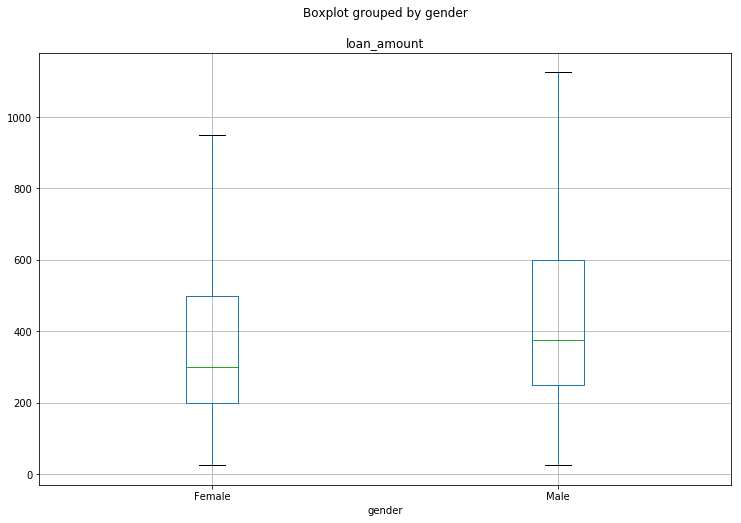

In [43]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='gender', showfliers=False, figsize=(12,8))

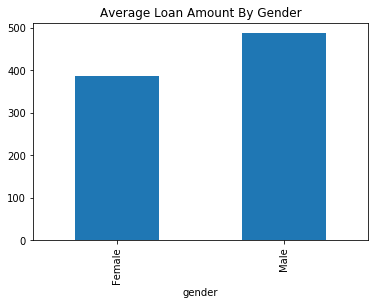

In [94]:
df[df['borrower_count'] == 1].groupby('gender')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

## Status and Age

In the first module, we only considered gender as a demographic feature. However, there could be other demographic features that influence the loan amount you request. 


Let's start with a broad exploration of of the description field. This will help showcase how to manipulate string data, and will also allow us to extract some interesting age and status related features.

In the cell below we use Numpy's  [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function  and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to create the widowed", "kids", and "elderly" features. 

We are using Numpy's filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest - in this case, any variation of the words widow, and any indication of children. Note that we try to be inclusive by testing for variations like "daughter" and "son."

In [99]:
## Whether or not the borrower is widowed
#  Note the str.contains function

df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0)==True, 1, 0)

## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=0) ==True,1,0)

## Whether or not the borrower is elderly
df['elderly'] = np.where(df['tags'].str.contains("#Elderly", na=0) ==True, 1, 0)

We create the features above because we had the hypothesis that age may drive the loan amount requested. However, all these new features face a data scarcity problem. We can see this by looking at the value_counts() of each new feature. 

In [ ]:
df['widowed'].value_counts()
df['kids'].value_counts()
df['elderly'].value_counts()

The words are only contained in a handful of descriptions. 'Kids' is probably our most useful field since it is contained in ~24,000 loan descriptions. 

**Data scarcity** reduces the utility of the new field as an explanatory feature because if most observations of the feature are missing, it will not be a good discriminator in predicting loans. To understand this, think about if we are trying to predict nationality using accent. There are 20 nationalities present, but everyone has the same accent. Accent will not be useful anymore in getting us closer to seperating nationalities, we should instead rely on other features. 

Despite the weakness of these features, this has still been a useful process. Many steps in feature development involve creating features that will not ultimately be used. It is through creative exploration that we will eventually pinpoint our winning features. In fact, this has given us the idea to more systematically extract age.

Below, we do one final validation step and plot the features we just extracted. You can see in the boxplots below that both elderly and widowed fo not differ much in the distribution of loan amount. That is another strong hint not to include them as features in our final model. Any good explanatory variable will cause variance in the explanatory variable.

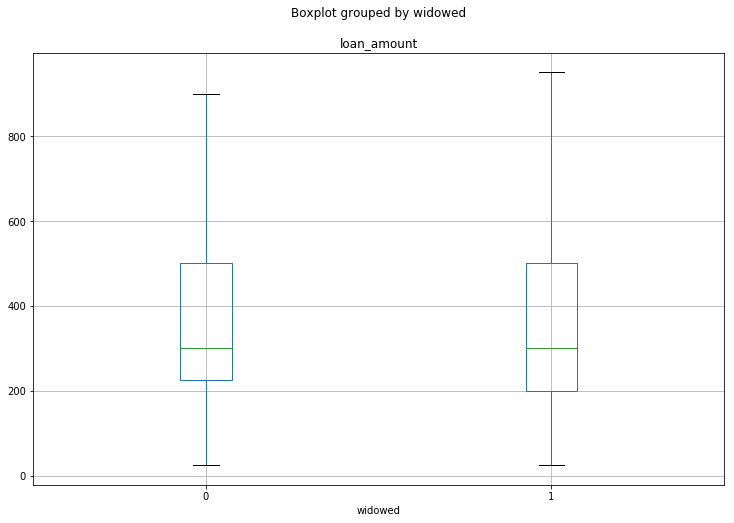

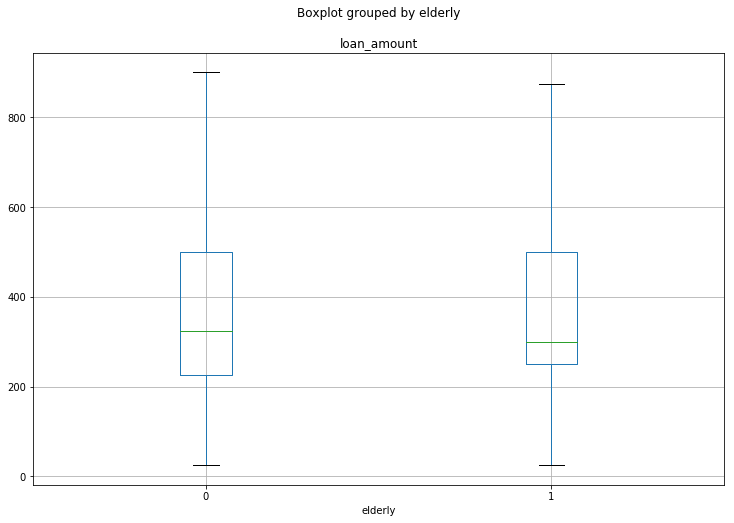

In [72]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='widowed', showfliers=False, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='elderly', showfliers=False, figsize=(12,8))

However, it is worth taking a closer look at kids. This field still faces a data scarcity issue, but we can see that lenders with kids do have a more narrow distribution than lenders without. It appears that parents are less likely to take high value loans.

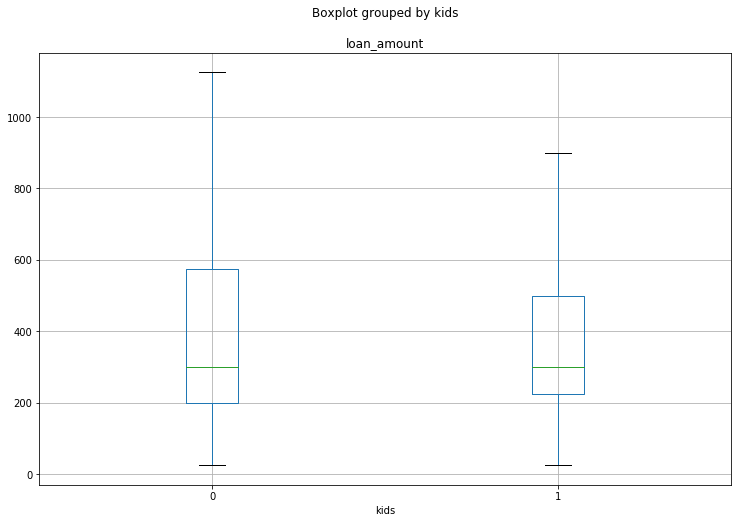

In [73]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='kids', showfliers=False, figsize=(12,8))

## Relationship Status

Before we move on, we read through a few descriptions and realize many loans mention whether the applicant is married. We decide to take a look at this feature by doing a text search for the word married, husband or wife.

1    78883
0    48949
Name: married, dtype: int64

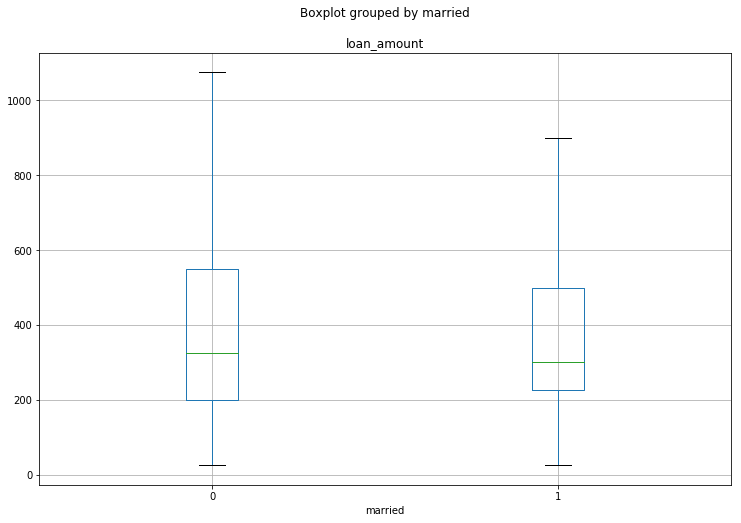

In [69]:
## Whether or not the borrower is elderly
df['married'] = np.where(df['description.texts.en'].str.contains("married|husband|wife", na=0) ==True, 1, 0)

df['married'].value_counts()

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='married', showfliers=False, figsize=(12,8))

We were right to take a look at it! Married has good coverage and it seems that lenders who are married typically request smaller loans. This suggests lenders who are married are willing to tolerate less risk. 

In the last class we discussed reasons that a woman might be requesting a lower loan amount. 

One of the hypotheses that came up was that a woman might need to ask permission from her husband to request a loan if she is married. Now we have a feature for whether someone is married we can put this to the test! 

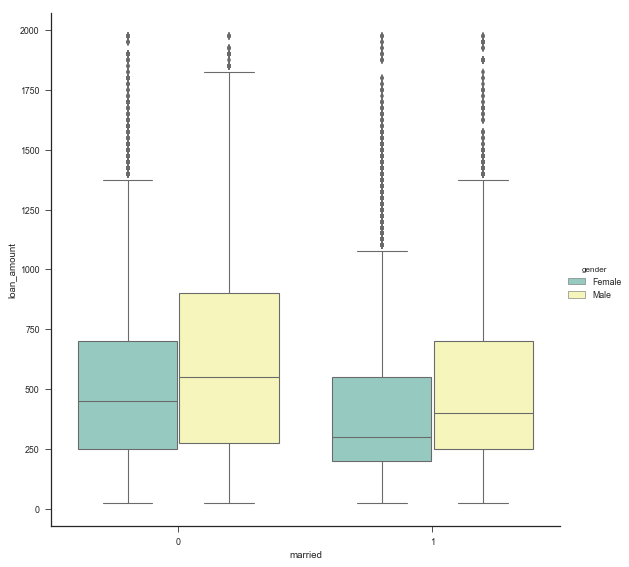

In [165]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="married", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

In fact we can see from the boxplot above that both married men and women tend to request lower amounts. Women consistently appear to request lowers amounts in both the married and unmarried groupings.

This reduces the strength of that hypothesis as one of the key reasons women request lower amounts.

The marriage field has turned out to be very interesting and we will definately include it in our model.


#### A note of caution!

While we are pleased with the results above, let's be aware that free form text is always going to be a problematic feature. For example, there may be inconsistencies in what people choose to say about themselves. We can fairly sure that when a person says they are married thay are in fact married, but if they don't it may just be by ommission. In other words, they may be married but choose not to report it on their loan application (there is no requirement they do so!).

The lack of a consistent way data is reported is a problem you will face again and again in data science. Often, when we find compelling results like the boxplot above it is a strong signal we should push for more systematic collection of those fields. This could take the form of a questions asking about marital status that can already be responded to with 'single', 'married', 'divorced'.

## Age and number of children

### More systematic string matching.

Our work with string matching has given us the idea to extract age and also number of children in a more systematic way. In the cells below, we parse out the **age** of the user by doing the following:

1. Importing a CSV mapping of age strings that appear in the Kiva description field (e.g. "2 years") to the integer counterparts (e.g. 2). 
2. We then define a function to check for each of these string values within the `description.texts.en` field of our main dataframe. If a match is found, we append that string value to a new list, "age", which we create at the start of the funtion. If no match is found, we append a blank string. When the function has completed, we have a list the same length of our main dataframe, with the corresponding age string value for each observation (e.g. "2 years" or " " if there is no age value available)
    1. We use functions from the [regular expression package](https://docs.python.org/2/library/re.html) to perform the string searches within the `description.texts.en`. Specifically, we use `re.compile` and  `re.findall` functions to first compile all possible age strings of interest, and then find all instances of the corresponding string.
3. We then create a new column in our main dataframe, "age", which is simply the list we created in step 2.
4. Finally, we perform a left join of our main dataframe with the CSV mapping, to map the string versions of age with their integer counterparts.



In [101]:
tags = pd.read_csv(data_path+'tags.csv')

In [102]:
tags.head(2)

,age,age_int,children,children_int
0,1 years,1,one child,1.0
1,2 years,2,two children,2.0


In [104]:
## Age of borrower and number of children

# define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function

def text_search(tag):
    #creates empty lists that are then added to in loop
    number=[]
    flag = tag.astype(str)
    match=flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['description.texts.en']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In the cell below we write a small loop to go through each feature and search. You can add other lists to the tags csv
to extend the features you search for.

In [106]:
features=['age','children'] 

for feature in features:
        number= text_search(tags[feature])
        df["number"]=pd.DataFrame(number)
        output=['number']
        name=[]
        #renames all columns with that feature name (e.g title), so that columns to not overwrite each other
        for x in output:
            name.append(feature+'_'+x)
        df.rename(columns=dict(zip(output, name)), inplace=True)

As always we take a look at our dataframe to make sure our loop was successful. Then we join in the int fields in our imported tags so we can treat these fields as a numerical variable (you will see we have successfully created age_int and children_int).

In [107]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,top_patner_id,top_partner_id,top_partner,widowed,kids,elderly,age,married,age_number,children_number
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,...,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,1.0,1.0,other,0,1,0,44 years,1,44 years,6 children
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,...,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,1.0,1.0,other,0,1,0,42 years,1,42 years,two children
2,2,2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,...,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:30:04,2017-06-08 00:30:03,NaN,2017-04-28 07:00:00,1,2017-04-28,2017,5,Female,1.0,156.0,Juhudi Kilimo,0,1,0,,1,,
3,3,3,3,Used Clothing,0.0,False,"[{'first_name': 'Jane', 'last_name': '', 'gend...",NaN,['en'],"Jane was born in the 1980, and she is happily ...",NaN,NaN,NaN,0,NaN,1291525,2515986,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Jane,386.0,[],2017-06-08

In [110]:
tags.sample(2)

,age,age_int,children,children_int
11,12 years,12,twelve children,12.0
120,121 years,121,NaN,NaN


In [111]:
df=df.merge(tags[['age','age_int']], how='left', left_on='age_number', right_on='age')
df=df.merge(tags[['children','children_int']], how='left', left_on='children_number', right_on='children')

We check out our dataframe below! So cool, we now have the number of children and the age in years where it is reported in the loan description.

In [113]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,top_patner_id,top_partner_id,top_partner,widowed,kids,elderly,age_x,married,age_number,children_number,age_y,age_int,children,children_int
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,...,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,1.0,1.0,other,0,1,0,44 years,1,44 years,6 children,44 years,44.0,6 children,6.0
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,...,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,1.0,1.0,other,0,1,0,42 years,1,42 years,two children,42 years,42.0,two children,2.0


## Number of children

From the quick check below, we see that we have good coverage for the number of children. We only have 58,000 missing.

In [121]:
df['children_number'].value_counts().nlargest(10)

                  58555
three children    14245
two children      13856
five children      6860
six children       4768
3 children         2917
four children      2780
seven children     2730
4 children         2537
2 children         2436
Name: children_number, dtype: int64

Now that all of our data processing is over, let's take a look at the number of children against loan amount. Very interesting! We see what appears to be a negative relationship, lenders with more children tend to request lower loan amounts.

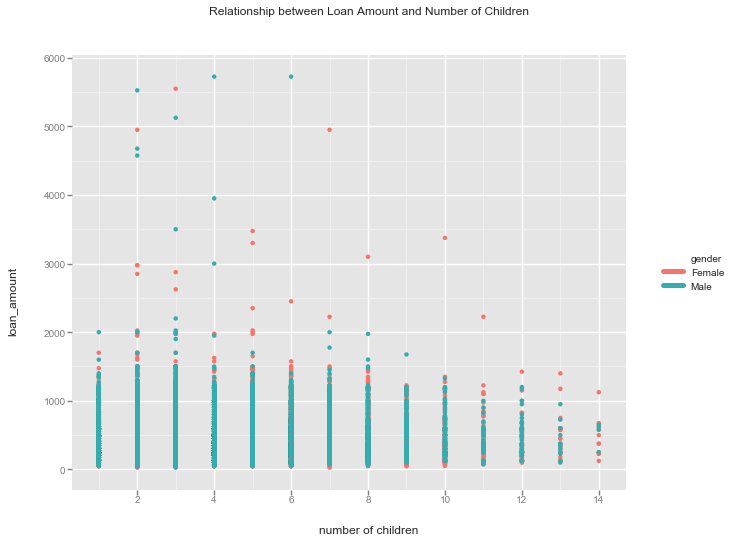

<ggplot: (357146197)>

In [174]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'children_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Children") + xlab("number of children") + ylab("loan_amount")

Surprisingly, in the chart above it appears that women may be requesting more than men? This is really surprising, since all our analysis of gender so far has communicated that women on average request less. Let's see what is going on by returning to our binary childrens boxplot from earlier.

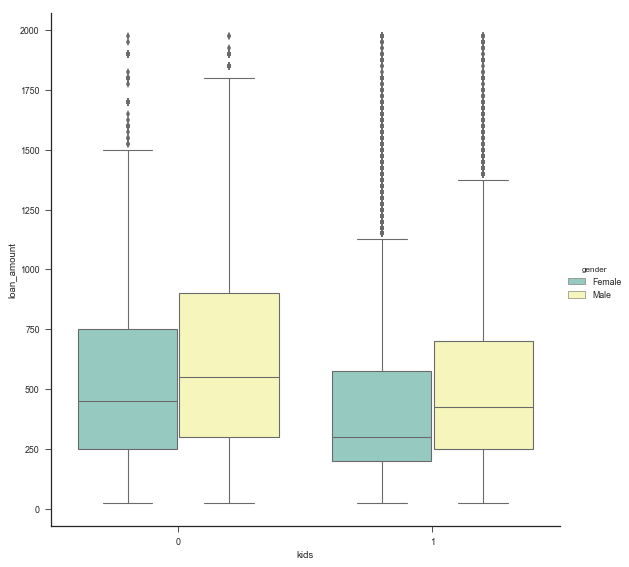

In [166]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="kids", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

It turns out this is not the case, men with children are still requesting more than women with children. This is why using a tool like boxplots is so important. It is a powerful way to quantify the distribution we percieve.

Let's also plot is using our more granular number of children data. This again reinforeces that women are systematically asking for less than men.

We can also note that although we percieved a negative relationship between number of children and loan amount requested in our initial scatter plot, it appears that at least the male median loan amount requested goes up as the number of children go up. 

The number of children feature is very promising, we will definately be including it in our model.

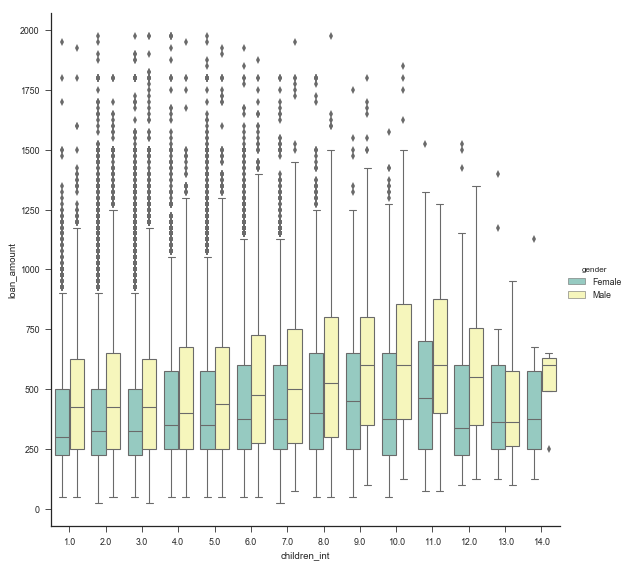

In [167]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="children_int", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

## Age

Now let's turn to age. Below, we plot age against loan amount to get a sense of the strength of the relationship.

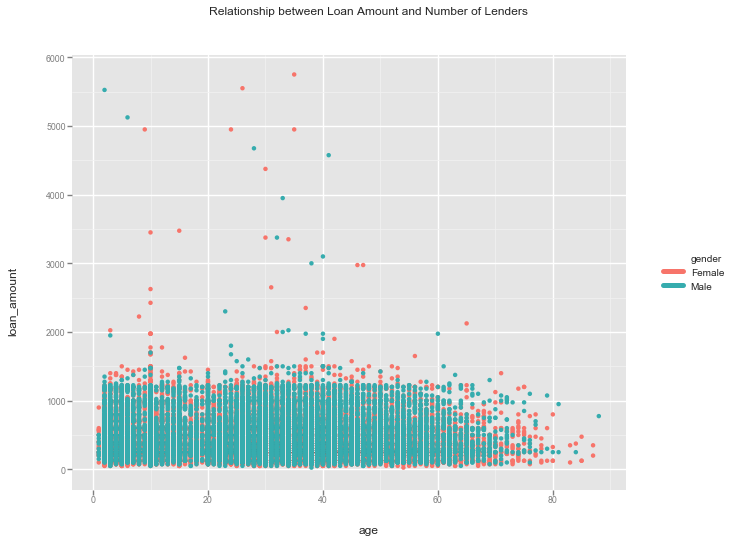

<ggplot: (302176583)>

In [123]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'age_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Lenders") + xlab("age") + ylab("loan_amount")

From the chart above, we can see that while we have learnt something about the age distribution it is unfortunately not particularly powerful at predicting loan amount. We decide to try one more thing and bucket age to see if it strengthens the relationship.

In [124]:
mybins =range(0, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
df['age_bucket'].value_counts()

(0, 10]     12706
(30, 40]    12524
(20, 30]     9629
(40, 50]     8555
(10, 20]     6401
(50, 60]     4806
(60, 70]     1596
(70, 80]      234
Name: age_bucket, dtype: int64

Strange -- looks like there are a lot of 10 year olds borrowers! This doesn't make sense, so let's take a look at the data where age_int < 10 to investigate. 

In [125]:
df[df['age_int']< 10].head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,top_patner_id,top_partner_id,top_partner,widowed,kids,elderly,age_x,married,age_number,children_number,age_y,age_int,children,children_int,age_bucket
95,96,96,96,Farm Supplies,0.0,False,"[{'first_name': 'George', 'last_name': '', 'ge...",NaN,['en'],George is a married man happily blessed with t...,NaN,NaN,NaN,0,NaN,1290533,2514679,1,0,0,0,1175,Kenya,KE,town,1 38,point,nyeri,George,386.0,[],2017-06-06,2017-05-07,Agriculture,fundraising,[{'name': '#Animals'}],120000.0,KES,2017-04-19T07:00:00Z,1175,...,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-07 19:10:09,2017-06-06 19:10:09,NaN,2017-04-19 07:00:00,1,2017-04-19,2017,5,Male,1.0,1.0,other,0,1,0,2 years,1,2 years,two children,2 years,2.0,two children,2.0,"(0, 10]"
127,128,128,128,Farming,NaN,False,"[{'first_name': 'Janet ', 'last_name': '', 'ge...",NaN,['en'],"Hello lenders! Meet Janet, a hardworking, hone...",NaN,NaN,NaN,200,2017-05-07,1290288,2514395,1,0,0,6,200,Kenya,KE,town,1 38,point,Siongiroi,Janet,156.0,[],2017-06-06,2017-05-07,Agriculture,funded,"[{'name': 'volunteer_pick'}, {'name': 'volunte...",20000.0,KES,2017-04-26T07:00:00Z,200,...,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-07 13:40:05,2017-06-06 13:40:05,2017-05-07 22:46:38,2017-04-26 07:00:00,1,2017-04-26,2017,5,Female,1.0,156.0,Juhudi Kilimo,0,1,0,5 years,1,5 years,,5 years,5.0,NaN,NaN,"(0, 10]"
252,253,253,253,Retail,0.0,True,"[{'first_name': 'Veronica', 'last_name': '', '...",NaN,['en'],Veronica is a married woman. She has 2 childre...,NaN,NaN,NaN,0,NaN,1288491,2511928,1,0,0,0,400,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Veronica,138.0,[],2017-06-04,2017-05-05,Retail,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",40000.0,KES,2017-04-25T07:00:00Z,400,...,10.519745,NaN,328197.0,1.0,18.498507,17262.0,SMEP Microfinance Bank,29.0,NaN,0.00,3.5,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2009-07-19T04:50:04Z,active,6764500.0,http://www.smep.co.ke/index.php,2017-05-05 13:10:03,2017-06-04 13:10:02,NaN,2017-04-25 07:00:00,1,2017-04-25,2017,5,Female,1.0,138.0,other,0,1,0,4 years,1,4 years,2 children,4 years,4.0,2 children,2.0,"(0, 10]"
258,259,259,259,Retail,NaN,True,"[{'first_name': 'Elizabeth', 'last_name': '', ...",NaN,['en'],Elizabeth is a married woman. She has 1 child....,NaN,NaN,NaN,500,2017-05-06,1288405,2511829,1,0,0,11,500,Kenya,KE,town,-0.983333 34.25,point,Migori,Elizabeth,138.0,[],2017-06-04,2017-05-05,Retail,funded,"[{'name': '#Woman Owned Biz'}, {'name': '#Eco-...",50000.0,KES,2017-04-25T07:00:00Z,500,...,10.519745,NaN,328197.0,1.0,18.498507,1

The data tells us that many people are not reporting their own age, but in fact are telling us about their young children. This reveals a big data integrity problem - the feature age_int is not what we thought it was. This raises the question of how many people reported their own age in the first place. 

One way to address this is to conservatively only look at observations where the age is more than 20. We do this below by starting at bins at 20.

In [126]:
mybins =range(20, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
##df['age_bucket'].value_counts()

(30, 40]    12524
(20, 30]     9629
(40, 50]     8555
(50, 60]     4806
(60, 70]     1596
(70, 80]      234
Name: age_bucket, dtype: int64

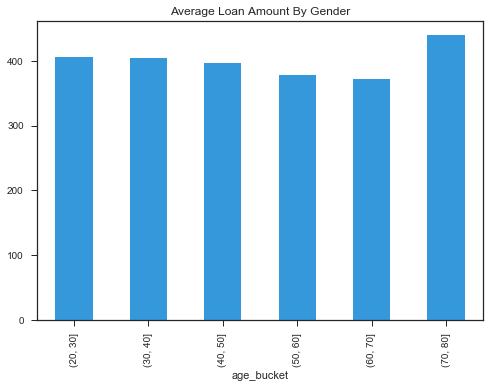

In [172]:
df[df['borrower_count'] == 1].groupby('age_bucket')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

Unfortunately, it did not improve the relationship. While 70-80 year olds appear to be requesting larger loans on avg it is very similar amounts for all other ages. But don't despair!

Again, meeting dead ends in feature engineering is a perfectly normal part of developing a model. We included all these weaker feature explorations so you can understand that even experienced data scientists try a lot of things that are not successful. 

The best way to build a successful model is to iterate quickly and not get stuck when a feature doesn't work out.

## Location

In [224]:
df.head('location.town']]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,top_patner_id,top_partner_id,top_partner,widowed,kids,elderly,age_x,married,age_number,children_number,age_y,age_int,children,children_int,age_bucket,time_to_expire_datetime,days_to_expire,eco_friendly,animals,technology
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,...,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,1.0,1.0,other,0,1,0,44 years,1,44 years,6 children,44 years,44.0,6 children,6.0,"(40, 50]",30 days,30.0,0,0,0
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,...,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,1.0,1.0,other,0,1,0,42 years,1,42 years,two children,42 years,42.0,two children,2.0,"(40, 50]",30 days,30.0,0,0,0


In [241]:
df['location']=df['location.town'].astype(str).str.cat(df['location.country'].astype(str), sep=' ')

df['location'].head(2)

In [ ]:
.apply(lambda x: (x.latitude, x.longitude)

In [248]:
location = df['location'].unique()
print(len(location))
d = dict(zip(location, pd.Series(location).apply(geolocator.geocode)))
d


df['location_coord'] = df['location'].map(d)
df

1247


GeocoderTimedOut: Service timed out

In [246]:
geolocator = Nominatim()
location = geolocator.geocode("litein Kenya")
print(location)

Litein, Kericho, Kenya


GeocoderTimedOut: Service timed out

In [ ]:


df['location_coord'] = df['location'].apply(geolocator.geocode)

location.raw

Litein, Kericho, Kenya


{'boundingbox': ['-0.6032999', '-0.5632999', '35.1633', '35.2033'],
 'class': 'place',
 'display_name': 'Litein, Kericho, Kenya',
 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_place_village.p.20.png',
 'importance': 0.38714730829695,
 'lat': '-0.5832999',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
 'lon': '35.1833',
 'osm_id': '44931317',
 'osm_type': 'node',
 'place_id': '220319',
 'type': 'village'}

In [ ]:
df['gender']=np.where(df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M'),"Male",(np.where(df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='F'),"Female","")))

## Step 2: Loan features

Next we create features related to the conditions surrounding each loan posting that we believe may drive loan amount.

## Sector and Activity

We know from our exploratory analysis in the last lesson that sector and activity are both important drivers of loan amount. We will be including both of these in our linear regression.

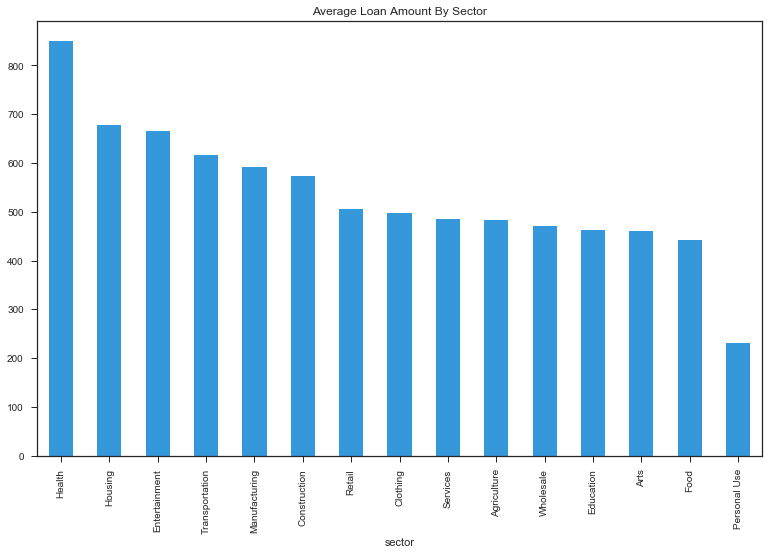

In [179]:
df[df['borrower_count'] == 1].groupby('sector')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Sector", figsize=(13, 8))

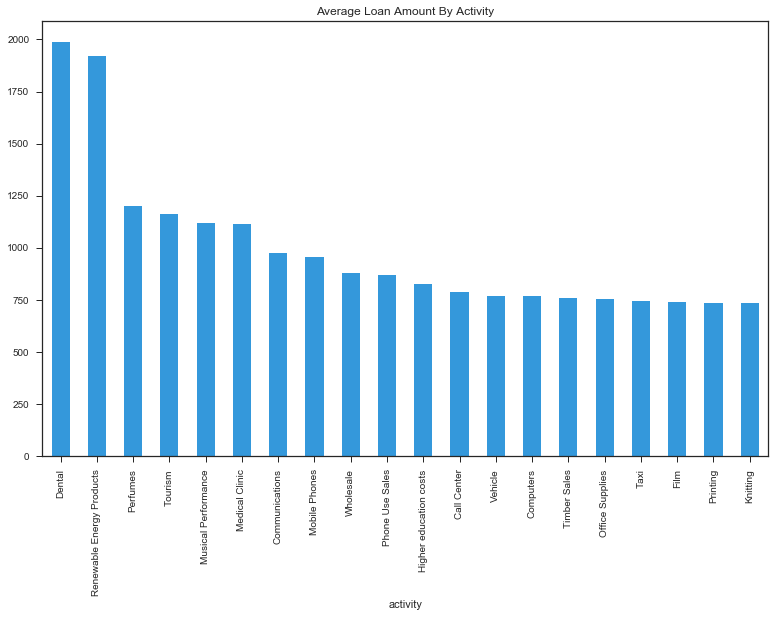

In [180]:
df[df['borrower_count'] == 1].groupby('activity')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Activity", figsize=(13, 8))

## Time features

In order to leverage time features, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them.

As we saw in Module 1, we already ensured our date features are converted to datetime format using the `to_datetime` function. However, in reading in our "df" csv file, Python forgot the Pandas format we assigned. Therefore we convert our created variables to datetime format again. We then create a day feature from each of the datetime differences we calculate.

In [176]:
## Ensuring datetime format
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_datetime'])
df['posted_datetime'] = pd.to_datetime(df['posted_datetime'])

## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_datetime'] =df['planned_expiration_datetime'] - df['posted_datetime']
df['days_to_expire'] = df.time_to_expire_datetime.dt.days
df['posted_year']=df['posted_datetime'].dt.year
df['posted_month']=df['posted_datetime'].dt.month

In [177]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,top_patner_id,top_partner_id,top_partner,widowed,kids,elderly,age_x,married,age_number,children_number,age_y,age_int,children,children_int,age_bucket,time_to_expire_datetime,days_to_expire
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,...,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,1.0,1.0,other,0,1,0,44 years,1,44 years,6 children,44 years,44.0,6 children,6.0,"(40, 50]",30 days,30.0
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,...,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,1.0,1.0,other,0,1,0,42 years,1,42 years,two children,42 years,42.0,two children,2.0,"(40, 50]",30 days,30.0


Do you remember the first exploratory notebook we plotted avg loan amount by year and found it fairly stable?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

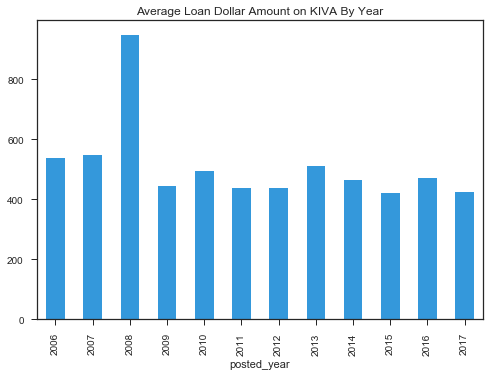

In [182]:
df.groupby('posted_year')['loan_amount'].mean().plot(kind="bar", title='Average Loan Dollar Amount on KIVA By Year')
plt.xticks(rotation=90)

Now, since we are trying to understand what drives loan amount, we restrict (as we have done in all charts so far) our dataset to loans with a single borrower. In the chart below, we plot the average loan amount by year. This restriction has a big impact on the relationshop, we see that the average loan amount goes down year over year.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

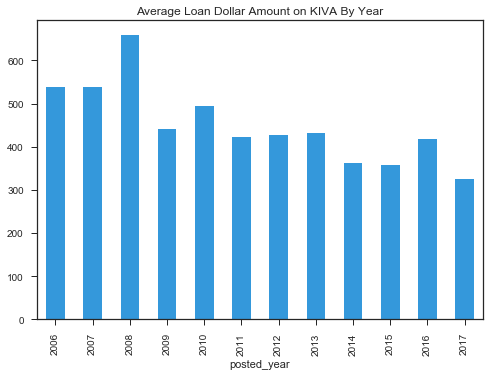

In [183]:
df[df['borrower_count'] == 1].groupby('posted_year')['loan_amount'].mean().plot(kind="bar", title='Average Loan Dollar Amount on KIVA By Year')
plt.xticks(rotation=90)

Why does loan amount requested go down? One possibility is that partners learn from experience what does and does not get funded. Remember our exploratory analsysis showed expired loans tended to be much larger on average. Perhaps lenders figured out their odds of success go up if they request lower amounts.

#### Do loans amounts spike at certain point during the year?

It might be interesting to also look at loan size by month. It is very possible that end-of-year celebrations or the beginning of the school year in January put a strain on household budgets and result in higher loan amount requests.

We can see below that the loan amount is on average higher in **November, December and February**. This seems to strengthen our hypothesis that loan amount is driven somewhat by seasonal preassures.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

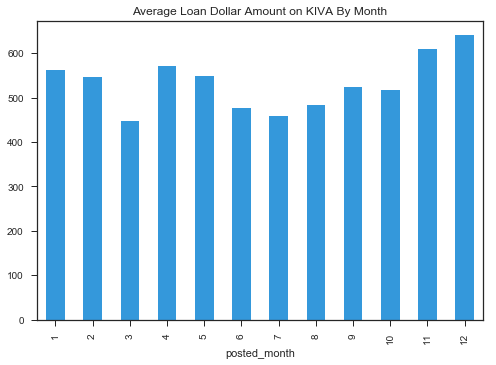

In [184]:
df.groupby('posted_month')['loan_amount'].mean().plot(kind="bar", title='Average Loan Dollar Amount on KIVA By Month')
plt.xticks(rotation=90)

As always, we follow-up with a box plot. This helps us understand the variance in loan amount between months. The results confirm our understanding that the distribution varies by month, we will include this feature.

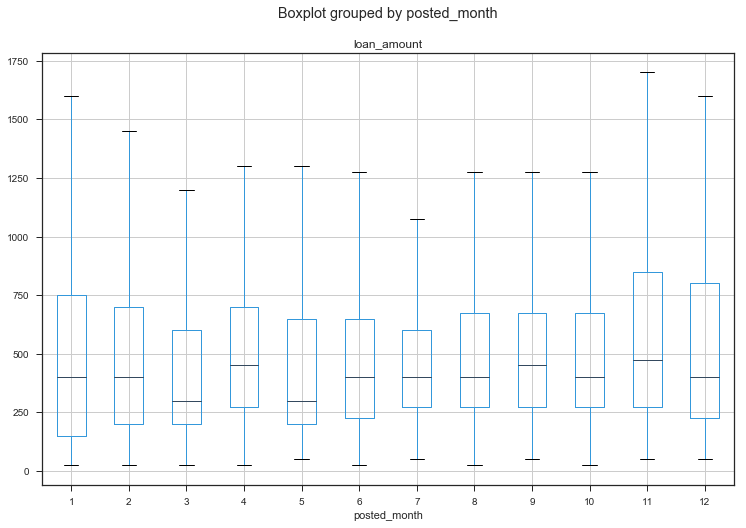

In [185]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='posted_month', showfliers=False, figsize=(12,8))

## Step 3: Partner Features

Recall from our exploratory analysis that KIVA relies heavily on it's partners to dispense loans in Kenya. In fact, only a negligable amount of loans are not associated with a partner. It is clearly important to take into account partner dynamics as we continue with our feature engineering.

## Partner Profitability and Financial Stability

How do partners affect loan amount? Does a partner's profitability have anything to do with the loan amount issued. Firstly, we evaluate a potential data issue where some partners have profitability below 0.

In [187]:
df[df['partner_profitability']<0]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,top_patner_id,top_partner_id,top_partner,widowed,kids,elderly,age_x,married,age_number,children_number,age_y,age_int,children,children_int,age_bucket,time_to_expire_datetime,days_to_expire
2,2,2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,...,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:30:04,2017-06-08 00:30:03,NaN,2017-04-28 07:00:00,1,2017-04-28,2017,5,Female,1.0,156.0,Juhudi Kilimo,0,1,0,,1,,,NaN,NaN,NaN,NaN,NaN,29 days 23:59:59,29.0
4,4,4,4,Farming,0.0,False,"[{'first_name': 'Alice', 'last_name': '', 'gen...",NaN,['en'],Alice (the woman pictured above in her small s...,NaN,NaN,NaN,0,NaN,1291518,2515975,1,0,0,0,400,Kenya,KE,town,1 38,point,Nandi Hills,Alice,156.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,[{'name': '#Woman Owned Biz'}],40000.0,KES,2017-05-27T07:00:00Z,400,...,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:20:03,2017-06-08 00:20:03,NaN,2017-05-27 07:00:00,1,2017-05-27,2017,5,Female,1.0,156.0,Juhudi Kilimo,0,0,0,,0,,,NaN,NaN,NaN,NaN,NaN,30 days 00:00:00,30.0
6,6,6,6,Farming,25.0,False,"[{'first_name': 'Mary', 'last_name': '', 'gend...",NaN,['en'],"Wonderful Kiva community, meet Mary (pictured ...",NaN,NaN,NaN,125,NaN,1291516,2515972,1,0,0,5,150,Kenya,KE,town,1 38,point,Kerugoya,Mary,156.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",15000.0,KES,2017-04-27T07:00:00Z,150,...,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:10:03,2017-06-08 00:10:03,NaN,2017-04-27 07:00:00,1,2017-04-27,2017,5,Female,1.0,156.0,Juhudi Kilimo,0,0,0,,0,,,NaN,NaN,NaN,NaN,NaN,30 days 00:00:00,30.0
8,8,8,8,Farming,0.0,False,"[{'first_name': 'Jacinta ', 'last_name': '', '...",NaN,['en'],Jacinta is 34 years old. She has four children...,NaN,NaN,NaN,0,NaN,1291494,2511365,1,0,0,0,600,Kenya,KE,town,-0.283333 36.066667,point,Nakuru,Jacinta,133.0,[],2017-06-07,2017-05-08,Agriculture,fundraising,[],60000.0,KES,2017-04-24T07:00:00Z,600,...,1495190.0,1.0,16.058249,30794.0,VisionFund Kenya,36.0,NaN,-1.7,2.5,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2009-05-29T11:35:11Z,active,11366975.0,http://www.visionfundkenya.co.ke/,2017-05-08 23

This is strange. We are not sure why there would be partners with profitability below 0. We plan to ask the KIVA team but until the will focus on partner delinquency.

Below we see that partner deliquency appears to have postive relationship with loan amount. This suggests that some partners may be requesting too high a loan amount, and are unable to pay it back. Instead, let's look at some other features that may drive loan amount. 

Two other patner features that are interesting are partner delinquency rate and the number of partner loans posted.

Why do you think we are interested in these features? What is a conceivable hypothesis?

#### Delinquency rate

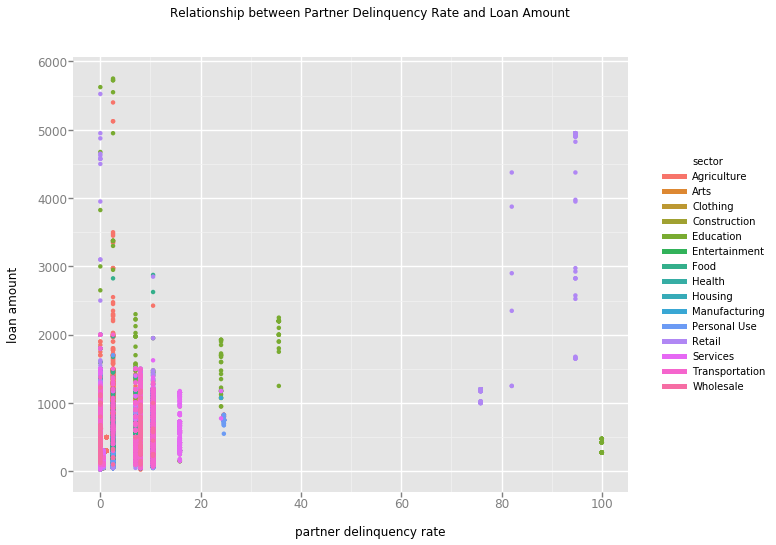

<ggplot: (-9223372036517342937)>

In [54]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_delinquency_rate', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Partner Delinquency Rate and Loan Amount") + xlab("partner delinquency rate") + ylab("loan amount")

We can see from the chart above that there does in fact appear to be a positive relationship between partner delinquency rate and loan amount. Additionally, it appear certain sectors (like construction and retail) have a higher risk of delinquency. Good to know! We will be including this feature in our model.

#### Number of Loans Posted

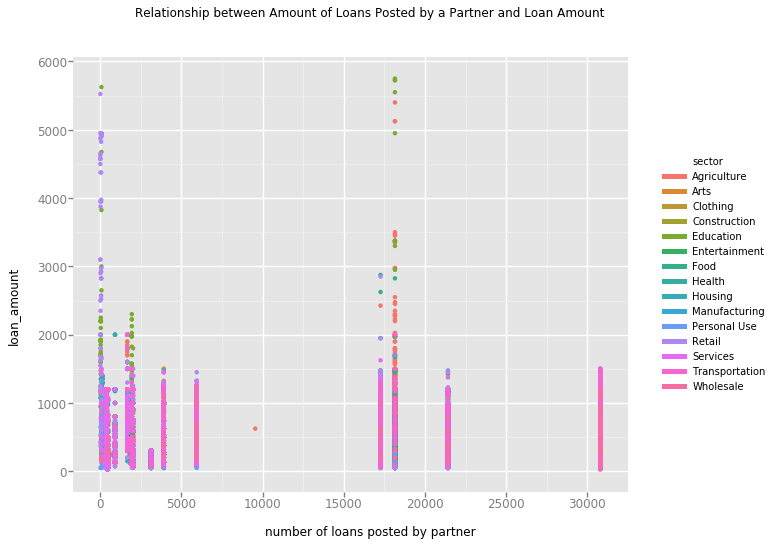

<ggplot: (-9223372036517087698)>

In [56]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_loans_posted', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Amount of Loans Posted by a Partner and Loan Amount") + xlab("number of loans posted by partner") + ylab("loan_amount")

The feature does seem initally promising, albeit weak. It suggests that as partner loans posted goes up the loan amont goes donw. The issue, as we can see in the chart above is that partner_loans_posted ends up serving as a unique identifier for a partner_id. While promising, we must make sure not to include both partner_loans_posted and partner_id because they are probably highly correlated. Ask in slack if you don't understand why this is true.

#### Loan Concentration

(array([], dtype=float64), <a list of 0 Text xticklabel objects>)

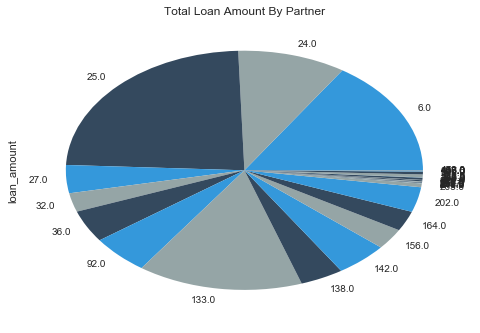

In [210]:
df.groupby('partner_id')['loan_amount'].sum().plot(kind="pie", title='Total Loan Amount By Partner')
plt.xticks(rotation=90)

In [211]:
# two functions below output new field where all partners not in top 5 are bucketed together.
# We have to do this in two different functions because partner_id and partner_name are different types. You can
# see this using our dtype code below.

df['partner_id'].dtype
df['partner_name'].dtype

def top_partners_id(x):
   partners_id = [] 
   for p in x:
        if p in [138.0, 133.0, 156.0, 164.0,202.0]:
           partners_id.append(p)
        else:
           partners_id.append(1.0)
   return partners_id

def top_partners(x):
   partners = []
   for p in x:
       if p in ['VisionFund Kenya', 'One Acre Fund', 'Juhudi Kilimo', 'Yehu Microfinance Trust', 'Faulu Kenya']:
           partners.append(p)
       else:
           partners.append('other')
   return partners

dtype('float64')

dtype('O')

In [212]:
df['top_partner_id'] = top_partners_id(df['partner_id'])
df['top_partner'] = top_partners(df['partner_name'])

In [213]:
df['top_partner'].value_counts()

other                      383136
VisionFund Kenya            85994
Faulu Kenya                 28329
Yehu Microfinance Trust     21570
Juhudi Kilimo               18079
One Acre Fund               10346
Name: top_partner, dtype: int64

When we plot out loan amounts by top_partner_id we immediately see something strange! Our boxplot for One Acre Fund, one of our biggest lenders disappears completely.

This happens because we are restricting our df['borrower_count'] == 1 (we are only looking at individual loans and not group loans). We accidentally discovered this really interesting quality of One Acre Fund loans, they are all group loans!

We can also see below that the top partners have variance in their distribution of loan amount! Interesting, this could be caused by the sectors they heavily lend to or by where they are located. What are some other reasons you can think of for this difference?

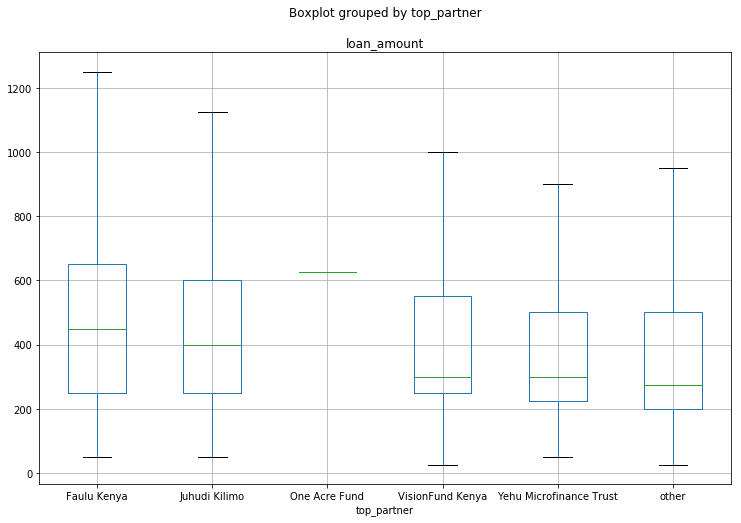

In [50]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='top_partner', showfliers=False, figsize=(12,8))

### Tag Features

Next we create features related to miscellaneous relevant information included in the loan's tags. Specifically, it could be interesting to consider the following: 
1. Is the loan eco-friendly?
2. Does the loan relate to animals?  
3. Does the loan involve technology?

As with the demographic features above, we are using Numpy's [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to search for relevant tag-words

In [214]:
## Is the loan eco-friendly?
df['eco_friendly'] = np.where(df['tags'].str.contains("#Eco-friendly", na=0) ==True, 1, 0)

## Does the loan relate to animals?
df['animals'] = np.where(df['tags'].str.contains("#Animals", na=0) ==True, 1, 0)

## Does the loan involve technology?
df['technology'] = np.where(df['tags'].str.contains("#Technology", na=0) ==True, 1, 0)

0    537767
1      9687
Name: eco_friendly, dtype: int64

0    540047
1      7407
Name: technology, dtype: int64

0    540526
1      6928
Name: animals, dtype: int64

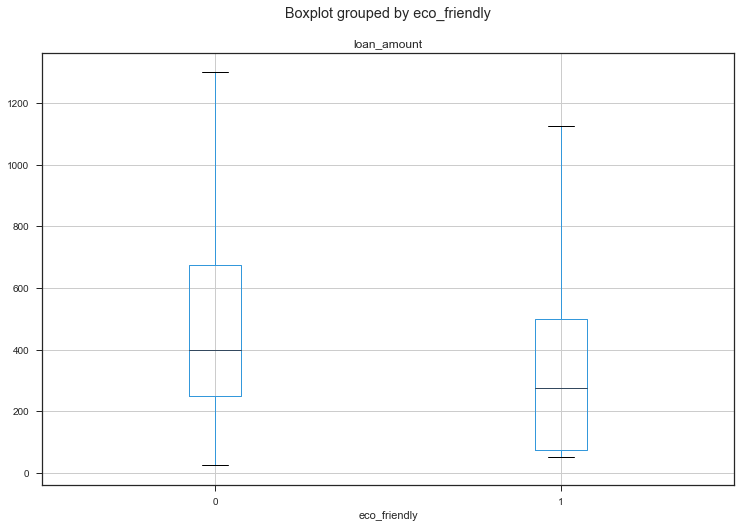

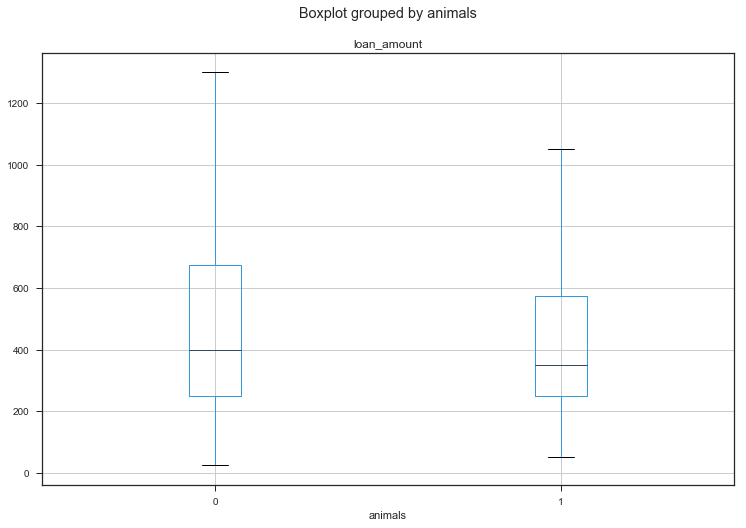

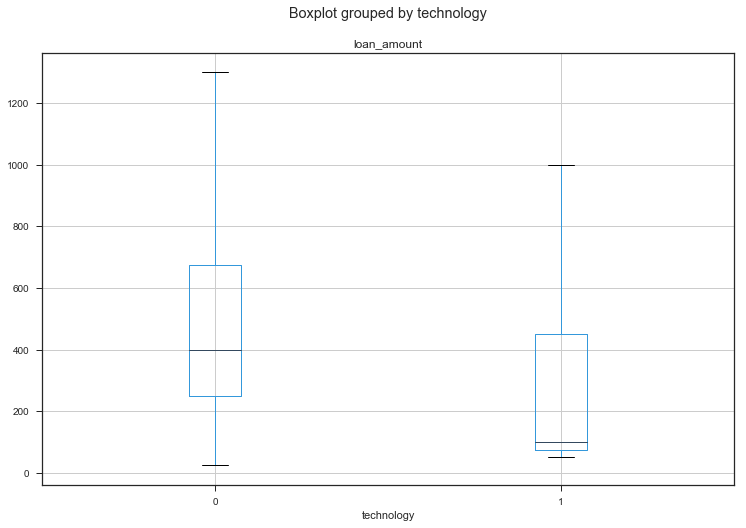

In [216]:
df['eco_friendly'].value_counts()
df['technology'].value_counts()
df['animals'].value_counts()


df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='eco_friendly', showfliers=False, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='animals', showfliers=False, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='technology', showfliers=False, figsize=(12,8))

## Checking Assumptions

### Normality
In Module 3, we reviewed that normal distribution of variables is an assumption underlying linear regression. Let's look first at our dependent variable, loan_amounts.

We already know our data is skewed by outliers, however before we begin modeling let's quantify the degree to which it is skewed.

[Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there are more loans in the left tail of the distribution. Typically, a skew score of +-5 is deemed acceptable.

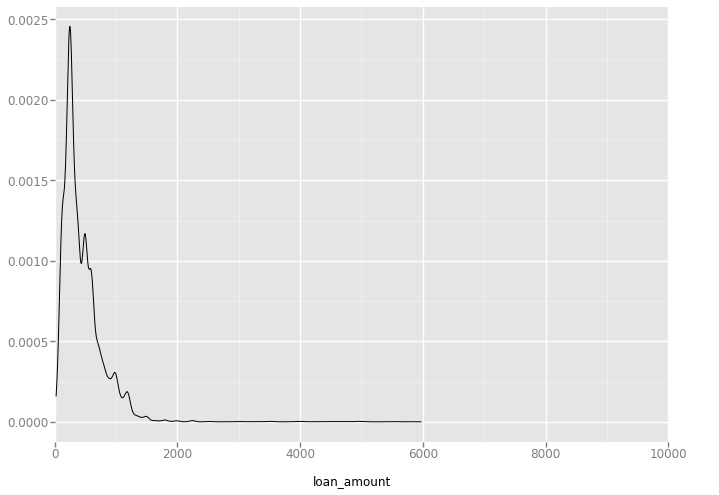

<ggplot: (-9223372036447235170)>

In [230]:
ggplot(df, aes(x='loan_amount')) + geom_density() + xlim(0,10000)

In [227]:
print(stats.skew(df.loan_amount, axis=None))

5.286819360746825


This confirms our suspicion that the data is skewed to the left. However, the degree to which it is skewed is not troubling. +-5 is fairly reasonable. In the cell below we describe a way to address this if you face a dataset with more severely skewed data.

## Additional context on how to deal with skewed data:


One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Try running different features!

In [231]:
np.corrcoef(df.loan_amount, df.funded_amount)

array([[ 1.        ,  0.95105949],
       [ 0.95105949,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [233]:
df_corr_tbl = df[['loan_amount','partner_loans_posted', 'posted_month', 'partner_delinquency_rate']]
df_corr_tbl.corr()

,loan_amount,partner_loans_posted,posted_month,partner_delinquency_rate
loan_amount,1.000000,-0.200950,-0.023244,0.013236
partner_loans_posted,-0.200950,1.000000,0.004218,0.315802
posted_month,-0.023244,0.004218,1.000000,0.008176
partner_delinquency_rate,0.013236,0.315802,0.008176,1.000000


Of course, not every correlation in this table will be meaningful. A correlation table is useful as it provides a visual shortcut to see what relationships might be problematic for multicollinearity. It appears we have no issues with collinearity.

## Linear Regression

Now we're relatively confident about what our data looks like, let's try some regressions. We will focus in on outcome feature loan_amount. We encourage you to explore other outcome features!  

As discussed in Module 2, we will divide the data into training and test sets so we can validate our regression results.

Note that training set should be larger than the test set, as we should train our model on as much data as possible. For this example, we divide the data 80% training / 20% test.

In [234]:
# Set training-test split %
split_pct = 0.80

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function. Let's try a simple example to start: 

In [235]:
model0 = sm.ols(formula="loan_amount ~ gender", data=train_set).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2075.
Date:                Wed, 31 May 2017   Prob (F-statistic):               0.00
Time:                        15:36:36   Log-Likelihood:            -9.4847e+05
No. Observations:              127832   AIC:                         1.897e+06
Df Residuals:                  127830   BIC:                         1.897e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        424.3059      1.362    311.

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = 424.30 + 110.90*male
    
Let's state the results. Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the loan amount increases by 110 dollars. This is consistent with our earlier explanatory analysis. How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. **But which ones?**

Before we move unto homework, remember to output your final dataframe so you don't have to rerun it.

In [ ]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

## Homework

Choose three other features you think might influence loan amount. Interpret the results by writing a statement like the one below that we wrote to understand the relationship with gender:

"Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the predicted loan amount increases by 110 dollars." 


### Univariate Regression 1

### Univariate Regression 2

### Univariate Regression 3

## Advanced Homework (Optional)

Multivariate regression is where there are multiple explanatory variables. Below is a code template for you to start playing with a multivariate model. Interpret your results.

In [ ]:
model1 = sm.ols(formula="[replace with the name of your outcome feature] ~[replace with the name of your explantory variable 1]  + [replace with the name of your explantory variable 1] +[replace with the name of your explantory variable 1] +", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

## Multivariate Regression

In [ ]:
model1 = sm.ols(formula="log_loan_amount ~ borrower_count + sector + kids + gender + widowed + pictured + video + posted_year +\
                days_to_expire + repayment_term + partner_profitability + eco_friendly + animals + elderly + technology", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

This **multi-feature** (or multivariate) model is more aligned with our understanding of the world. Most coefficients have very low p-values - a good sign! 

Our Adjusted R Squared is higher than it was in the single-feature model. Let's get into how we evaluate the model in terms of predictiveness. 

## Model Validation

<i>How can we evaluate how our model is doing? </i>

In the previous section, we were able to get general ideas of how well our model was doing by using metrics like Adjusted R Squared, coefficients, and p-value. However, the goal of most machine learning is a model that can <b>predict outcome features accurately</b>. Recall that we randomly split our dataset into a training set (80%) and a test set (20%). Now we will use the results from the regression conducted on our training set to predict the outcome features for each observation in our test set. The difference between the predicted outcome feature and the actual outcome feature for each observation gives us an idea of how close we are to the mark.  

In the previous section, we used the **statsmodel** package in order to output a regression output table. Now, we run the regression using the **scikit-learn** package, which is optimized specifically for machine learning and allows us to validate our models easily. Remember this package - we will be returning to it for the rest of the class!  

## Model Validation using scikit learn

In order to use scikit-learn to run a regression, we format the data differently than how we do when we use statsmodels. 

In scikit-learn, we want to make sure: 
1. Categorical features are converted Booleans with values of either 1 or 0
2. Data is separated into two separate and clean datasets: x and y, or explanatory features and outcome feature. 

We do this below in the pre-processing section.

## Next Steps

Next monday, we will go over your results and well as show you what we did for the multivariate regression. Next, we move on to a new algorithm (decision trees). Very exciting!